# Character Mentions Analysis (First Half vs. Second Half)
Topic: Notebook Setup & Configuration. Goal: Initialize the environment and import necessary tools. Action: We import libraries for text processing (nltk), data handling (pandas), and plotting (matplotlib), and ensure standard text processing models are downloaded.

In [61]:
import os, re, math, collections, itertools
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk

# Ensure NLTK tokenizer is available
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

# Define standard paths
data_dir = os.path.join('..', 'data')
results_dir = os.path.join('..', 'results')

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

print("Setup complete. Libraries loaded.")

Setup complete. Libraries loaded.


---

## 1. Load and Clean Text
Topic: Data Ingestion. Goal: Load the raw book text while removing license headers and footers. Action: We detect the .txt file, read it, and strip out Project Gutenberg metadata to ensure we only analyze the novel's actual content.

In [62]:
# Automatic detection of .txt files
txt_files = []
if os.path.exists(data_dir):
    txt_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith('.txt')])

# Select the first file found
book_file = txt_files[0] if txt_files else None
book_path = os.path.join(data_dir, book_file) if book_file else None

def load_and_clean_text(path):
    if not path or not os.path.exists(path):
        raise FileNotFoundError(f'Book file not found at {path}')
        
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
        
    # Remove Project Gutenberg Header
    start = re.search(r'\*\*\* *START OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*', text, flags=re.I|re.S)
    if start:
        text = text[start.end():]
    else:
        # Fallback to first Chapter marker
        m = re.search(r'\n(CHAPTER|BOOK|PART)\b', text, flags=re.I)
        if m:
            text = text[m.start():]
            
    # Remove Project Gutenberg Footer
    end = re.search(r'\*\*\* *END OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*', text, flags=re.I|re.S)
    if end:
        text = text[:end.start()]
        
    # Normalize whitespace
    text = re.sub(r'\r\n', '\n', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load the text
raw_text = load_and_clean_text(book_path) if book_path else ''
print(f"Selected Book: {book_file}")
print(f"Text Length: {len(raw_text)} characters")

Selected Book: The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt
Text Length: 1956022 characters


---

## 2. Split Text into Halves
Topic: Segmentation. Goal: Divide the narrative into two equal parts to compare character arcs over time. Action: We find the midpoint of the text and snap the split to the nearest chapter boundary (within 2000 characters) to avoid cutting a scene in the middle.

In [63]:
if not raw_text:
    first_half = second_half = ''
else:
    mid = len(raw_text) // 2
    # Look for a chapter boundary near the middle (+/- 2000 chars)
    window = 2000
    left = max(0, mid - window)
    right = min(len(raw_text), mid + window)
    
    split_match = re.search(r'\n(CHAPTER|BOOK|PART)\b', raw_text[left:right], flags=re.I)
    
    if split_match:
        split_index = left + split_match.start()
        first_half = raw_text[:split_index]
        second_half = raw_text[split_index:]
        print("Split method: Nearest Chapter Boundary")
    else:
        first_half = raw_text[:mid]
        second_half = raw_text[mid:]
        print("Split method: Exact Middle (No chapter boundary found)")

print(f'First half: {len(first_half)} chars')
print(f'Second half: {len(second_half)} chars')

Split method: Exact Middle (No chapter boundary found)
First half: 978011 chars
Second half: 978011 chars


---

## 3. Extract Name Candidates
Topic: Pattern Matching (NER). Goal: Identify potential character names in the text. Action: We use a regex to capture sequences of capitalized words (e.g., "Anna", "Anna Karenina", "Prince Stepan Arkadyevitch").

In [64]:
def extract_name_candidates(text):
    # Regex for 1-3 capitalized words, allowing hyphens/apostrophes
    pattern = r"\b([A-Z][a-zA-Z\-']+(?:\s+[A-Z][a-zA-Z\-']+){0,2})\b"
    matches = re.findall(pattern, text)
    return matches

# Extract candidates from the whole book to build our vocabulary
if raw_text:
    candidates = extract_name_candidates(raw_text)
    cand_counts = Counter(candidates)
    print(f'Distinct name candidates found: {len(cand_counts)}')
else:
    cand_counts = Counter()

# Show top 10 raw matches (includes noise like "The")
print("Sample raw matches:", cand_counts.most_common(10))

Distinct name candidates found: 2028
Sample raw matches: [('Levin', 1472), ('He', 1320), ('The', 1097), ('But', 1077), ('And', 1040), ('She', 891), ('Vronsky', 813), ('Anna', 727), ('Kitty', 653), ('It', 595)]


---

## 4. Canonicalize Names (Alias Mapping)
Topic: Data Normalization. Goal: Merge different variations of a name (e.g., "Anna", "Karenina", "Arkadyevna") into a single character identity. Action: We define a dictionary of known aliases for the main characters and map all raw candidates to these canonical names.

In [65]:
# Dictionary mapping aliases to the Single Canonical Name
name_mapping = {
    # ANNA
    "Anna": "Anna", "Karenina": "Anna", "Arkadyevna": "Anna", 
    "Anna Arkadyevna": "Anna", "Anna Karenina": "Anna",
    # VRONSKY
    "Vronsky": "Vronsky", "Count Vronsky": "Vronsky", "Alexey Kirillovitch": "Vronsky",
    # LEVIN
    "Levin": "Levin", "Konstantin": "Levin", "Konstantin Levin": "Levin", 
    "Dmitrievitch": "Levin",
    # KITTY
    "Kitty": "Kitty", "Ekaterina": "Kitty", "Scherbatskaya": "Kitty",
    # STIVA
    "Stiva": "Stiva", "Oblonsky": "Stiva", "Stepan": "Stiva", "Stepan Arkadyevitch": "Stiva",
    # KARENIN
    "Karenin": "Karenin", "Alexey Alexandrovitch": "Karenin",
    # DOLLY
    "Dolly": "Dolly", "Darya": "Dolly",
    # BETSY
    "Betsy": "Betsy", "Tverskaya": "Betsy"
}

def canonicalize_name(name):
    # 1. Clean punctuation
    n = name.strip().strip('.,;:\"\'')
    
    # 2. Check explicit map (Case Insensitive)
    for key, val in name_mapping.items():
        if key.lower() == n.lower():
            return val
            
    # 3. Check partial matches for main characters
    n_lower = n.lower()
    if "vronsky" in n_lower: return "Vronsky"
    if "levin" in n_lower: return "Levin"
    if "karenina" in n_lower: return "Anna"
    if "oblonsky" in n_lower: return "Stiva"
    if "karenin" in n_lower and "anna" not in n_lower: return "Karenin"

    # 4. Fallback: Use last token (for minor characters)
    parts = n.split()
    if not parts: return ""
    if len(parts) == 1: return parts[0]
    if parts[-1].lower() in ('the','a','an') and len(parts) > 1:
        return parts[-2]
    return parts[-1]

# Create the map
raw_to_canon = {}
for name in cand_counts:
    raw_to_canon[name] = canonicalize_name(name)

print("Canonicalization map built.")

Canonicalization map built.


---

## 5. Filter Non-Names
Topic: Data Cleaning. Goal: Remove capitalized words that are not people (e.g., "The", "Chapter", "But"). Action: We apply a "blocklist" of common stopwords and structural markers to refine the candidate list.

In [66]:
blacklist = set([
    'The','A','An','It','He','She','They','His','Her','This','That','In','On','At',
    'But','And','Of','To','From','By','For','With','As','Is','Was','Are','Be',
    'Have','Has','Had','Not','Chapter','Book','PART','Part', 'Well', 'Yes', 'No', 'You', 'How', 'Oh', 'What', 'Why', 'There', 'If', 'Moscow', 'When', 'We', 'All'
])

def is_good_candidate(token):
    if not token or len(token) < 2: return False
    if token in blacklist: return False
    if re.search(r"\d", token): return False # Remove numbers
    return True

# Helper function to count mentions in a text block
def count_mentions(text, map_dict):
    names = extract_name_candidates(text)
    c = Counter()
    for raw in names:
        canon = map_dict.get(raw, canonicalize_name(raw))
        if is_good_candidate(canon):
            c[canon] += 1
    return c

print("Filter logic ready.")

Filter logic ready.


---

## 6. Build Data Table
Topic: Data Aggregation. Goal: Compute the frequency of each character in the First Half, Second Half, and Total. Action: We run the counting function on our text segments and create a Pandas DataFrame sorted by total mentions.

In [67]:
# Count mentions in each section
counts_first = count_mentions(first_half, raw_to_canon)
counts_second = count_mentions(second_half, raw_to_canon)
counts_whole = count_mentions(raw_text, raw_to_canon)

# Build DataFrame for Top 20 characters
topN = 20
all_chars = [name for name, _ in counts_whole.most_common(topN)]

rows = []
for name in all_chars:
    rows.append({
        'name': name,
        'first': counts_first.get(name, 0),
        'second': counts_second.get(name, 0),
        'total': counts_whole.get(name, 0)
    })

df = pd.DataFrame(rows).set_index('name')
print("Top Characters Table:")
display(df)

Top Characters Table:


,first,second,total
name,,,
Levin,809,851,1660
Vronsky,476,391,867
Anna,380,462,842
Stiva,374,348,722
Kitty,371,299,670
Karenin,352,264,616
Dolly,130,179,309
Ivanovitch,109,185,294
Alexandrovna,90,123,213


---

## 7. Visualization: Comparison Bar Chart
Topic: Comparative Analysis. Goal: Visualize how character prominence shifts between the first and second half. Action: We plot a grouped horizontal bar chart. Long "First Half" bars indicate early disappearance; long "Second Half" bars indicate late emergence.

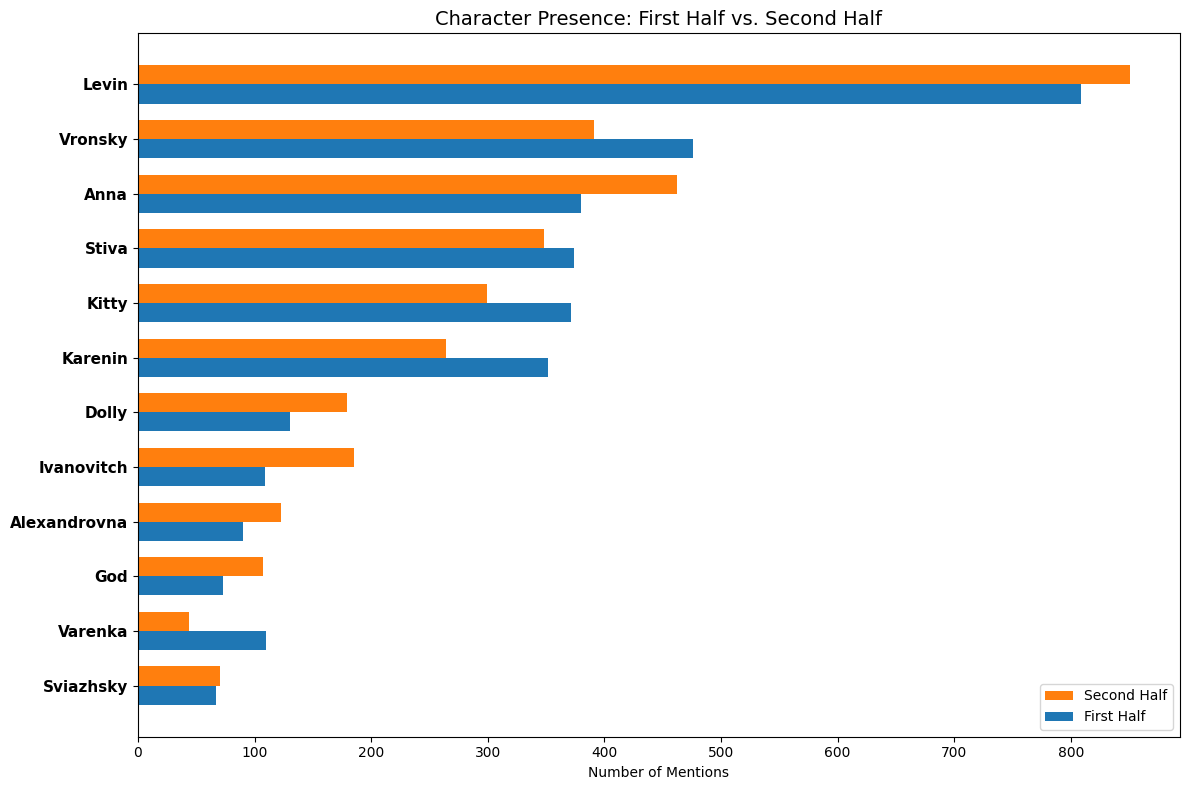

In [68]:
# Select top 12 for plotting
plot_df = df.head(12).sort_values('total', ascending=True) # Sort ascending for horiz bar
characters = plot_df.index.tolist()
y = np.arange(len(characters))

fig, ax = plt.subplots(figsize=(12, 8))
width = 0.35

# Plot bars
rects1 = ax.barh(y + width/2, plot_df['second'], width, label='Second Half', color='#ff7f0e')
rects2 = ax.barh(y - width/2, plot_df['first'], width, label='First Half', color='#1f77b4')

# Formatting
ax.set_yticks(y)
ax.set_yticklabels(characters, fontsize=11, fontweight='bold')
ax.set_xlabel('Number of Mentions')
ax.set_title('Character Presence: First Half vs. Second Half', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "mentions_comparison_bar.png"))
plt.show()

---

## 8. Visualization: Donut Chart
Topic: Composition Analysis. Goal: Show the "Share of Voice" for the top characters across the entire book. Action: We plot a donut chart where the size of each slice corresponds to the character's total mentions.

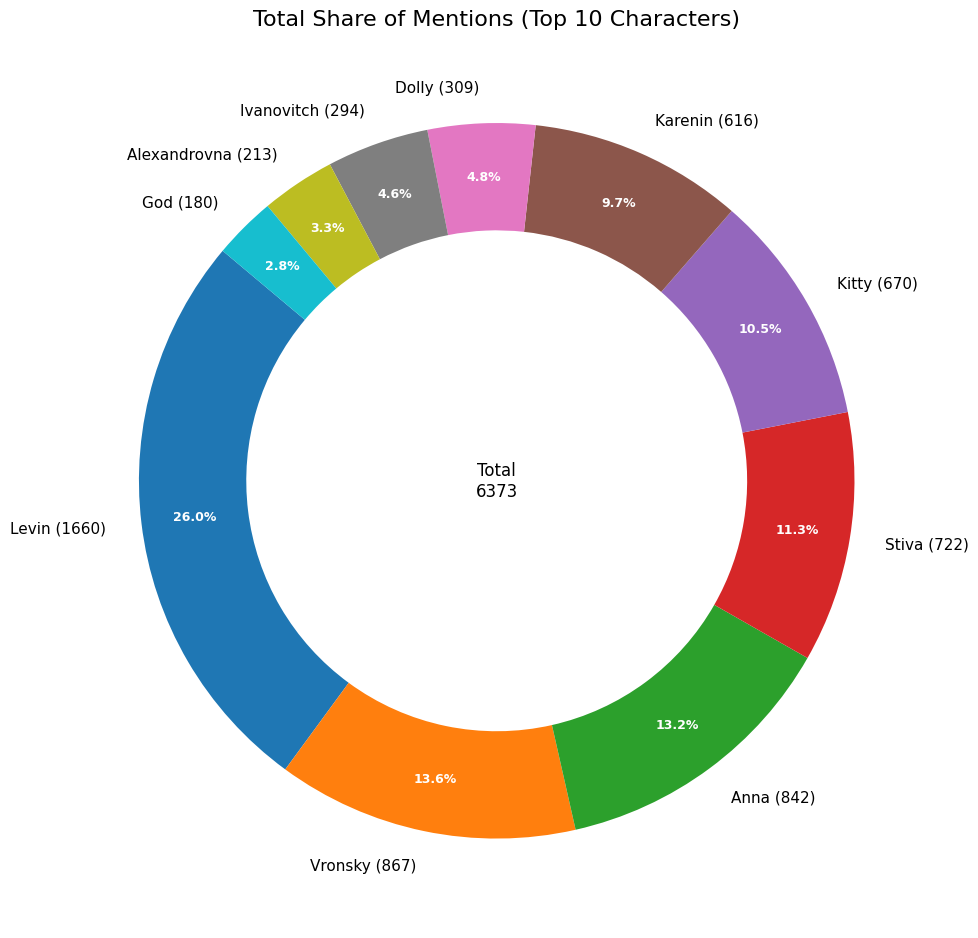

Saved donut chart to: ..\results\mentions_donut_chart.png


In [69]:
# Robust donut pie chart cell (paste to replace the old one)
import os

# Ensure results_dir exists (fall back if not defined)
results_dir = globals().get('results_dir',
                            os.path.abspath(os.path.join(os.getcwd(), '..', 'results')))
os.makedirs(results_dir, exist_ok=True)

# Data for Top 10 (assumes `df` exists and index are character names)
donut_df = df.head(10).copy()
sizes = donut_df['total']
labels = [f"{n} ({c})" for n, c in zip(donut_df.index, sizes)]

fig, ax = plt.subplots(figsize=(10, 10))

# Note: ax.pie may return (wedges, texts) or (wedges, texts, autotexts) depending on matplotlib version
res = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85,
    wedgeprops=dict(width=0.3)  # Makes it a donut
)

# Unpack safely
if len(res) == 3:
    wedges, texts, autotexts = res
else:
    wedges, texts = res
    autotexts = []

# Style labels and autotexts (only if they exist)
plt.setp(texts, size=11)
if autotexts:
    plt.setp(autotexts, size=9, weight="bold", color="white")

ax.set_title("Total Share of Mentions (Top 10 Characters)", fontsize=16)

# Center text
total_mentions = int(sizes.sum())
ax.text(0, 0, f"Total\n{total_mentions}", ha='center', va='center', fontsize=12)

plt.tight_layout()
out_path = os.path.join(results_dir, "mentions_donut_chart.png")
fig.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved donut chart to: {out_path}")


---

## 9. Visualization: Stacked Bar Chart
Topic: Distribution Analysis. Goal: Visualize total importance while simultaneously showing the split between halves. Action: We plot a stacked bar chart. The total length shows overall rank, and the color split shows temporal distribution.

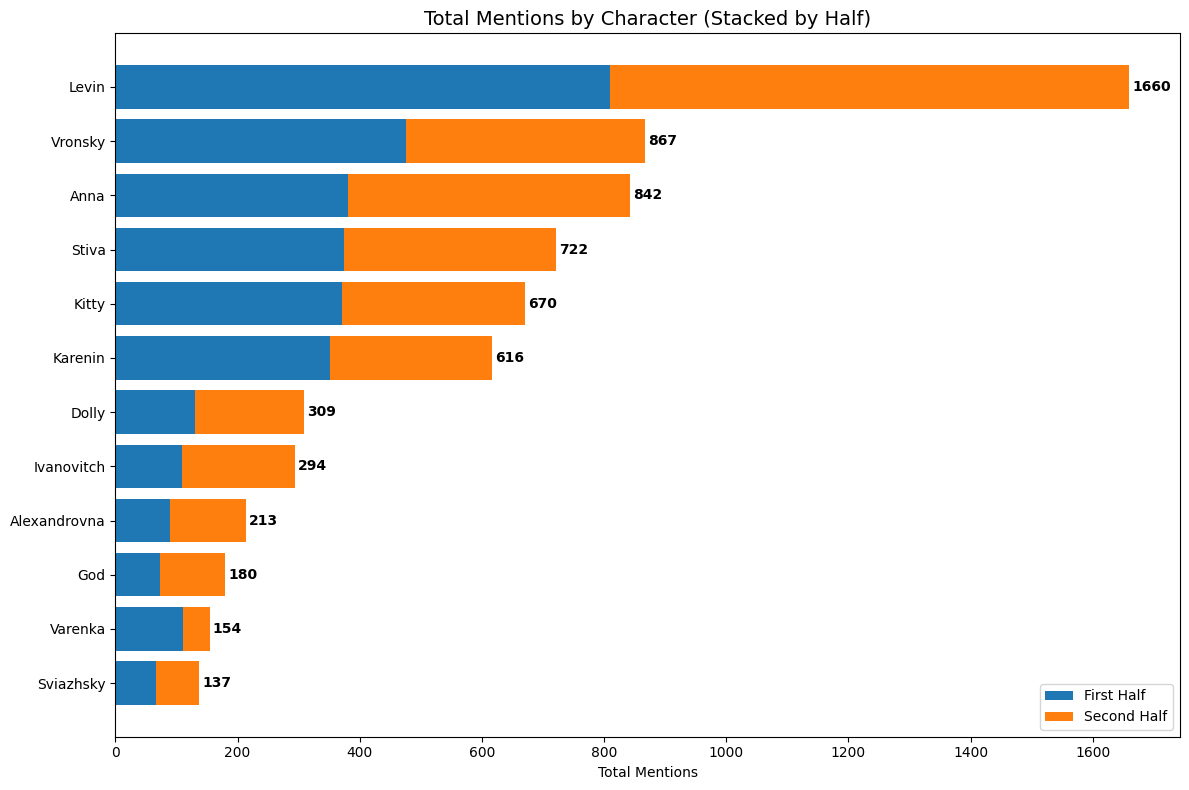

In [70]:
# Sort descending for stacked
stack_df = df.head(12).sort_values('total', ascending=True)
chars = stack_df.index
firsts = stack_df['first']
seconds = stack_df['second']

fig, ax = plt.subplots(figsize=(12, 8))

# Stacked bars
ax.barh(chars, firsts, label='First Half', color='#1f77b4')
ax.barh(chars, seconds, left=firsts, label='Second Half', color='#ff7f0e')

# Labels
ax.set_xlabel('Total Mentions')
ax.set_title('Total Mentions by Character (Stacked by Half)', fontsize=14)
ax.legend()

# Add total labels
for i, total in enumerate(stack_df['total']):
    ax.text(total + 5, i, str(total), va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "mentions_stacked_bar.png"))
plt.show()

---

## 10. Export Data
Topic: Data Persistence. Goal: Save the processed metrics to a CSV file for reporting. Action: We write the final DataFrame to the results directory.

In [71]:
output_path = os.path.join(results_dir, "character_mentions_stats.csv")
df.to_csv(output_path)
print(f"Data saved to: {output_path}")

Data saved to: ..\results\character_mentions_stats.csv


---

## 11. Summary & Interpretation
Topic: Narrative Analysis. Goal: Translate the data into literary insights about Anna Karenina. Action: We provide key takeaways based on the charts generated above.

In [72]:
# Print a simple text summary based on the data
print("=== ANALYSIS SUMMARY ===")

# 1. Who is the main character?
top_char = df.iloc[0].name
top_count = df.iloc[0]['total']
print(f"1. DOMINANCE: The most mentioned character is {top_char} with {top_count} mentions.")

# 2. Who is the 'Rising Star'?
# Calculate growth: (Second Half - First Half)
df['growth'] = df['second'] - df['first']
rising_star = df.sort_values('growth', ascending=False).iloc[0]
print(f"2. RISING STAR: {rising_star.name} has the biggest increase in presence (+{int(rising_star['growth'])} mentions in the 2nd half).")

# 3. Who is the 'Fading Star'?
fading_star = df.sort_values('growth', ascending=True).iloc[0]
print(f"3. FADING STAR: {fading_star.name} drops off the most ({int(fading_star['growth'])} mentions in the 2nd half).")

print("\n=== LITERARY CONTEXT ===")
print("If Levin is the 'Rising Star', it confirms the structural shift of the novel towards his philosophical plot.")
print("If Anna is the 'Fading Star', it quantitatively reflects her isolation and eventual tragic exit.")

=== ANALYSIS SUMMARY ===
1. DOMINANCE: The most mentioned character is Levin with 1660 mentions.
2. RISING STAR: Veslovsky has the biggest increase in presence (+110 mentions in the 2nd half).
3. FADING STAR: Karenin drops off the most (-88 mentions in the 2nd half).

=== LITERARY CONTEXT ===
If Levin is the 'Rising Star', it confirms the structural shift of the novel towards his philosophical plot.
If Anna is the 'Fading Star', it quantitatively reflects her isolation and eventual tragic exit.


---


## 12. Troubleshooting & FAQ
Topic: Maintenance. Goal: Help users fix common issues if the notebook fails. Action: A reference list of common errors and their solutions.

## Final notes and troubleshooting

- If the candidate list misses important characters, tweak the canonicalization rules in the 'Clean and canonicalize names' cell, or increase `topN` in the counting cell.
- If you prefer a higher-quality named-entity extraction, you can use `spaCy` with a suitable model (e.g., `en_core_web_sm`) — this requires adding the model install step and possibly `spaCy` to `requirements.txt` (your file already includes `spacy>=3.7.2`, but remember to download a model: `python -m spacy download en_core_web_sm`).
- If your `.txt` filenames differ, set `book_file` to the exact filename in the first code cell.

